In [91]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

from torchvision import transforms
from torchvision.datasets import MNIST

from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [156]:
def get_MNIST(batch_size):
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

    dataset = MNIST('data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    return dataloader

In [157]:
batch_size = 64
dataloader = get_MNIST(batch_size=batch_size)

In [ ]:
def plot_images(images, title, saved=False):        
    images = images * 0.3081 + 0.1307
    np_images = images.detach().cpu().numpy()
    
    fig = plt.figure(figsize=(10,10))
    
    n_cols = int(np.sqrt(len(images)))
    n_rows = len(images) // n_cols
    index = 0
    
    for i in range(n_rows):
        for j in range(n_cols):
            fig.add_subplot(n_rows, n_cols, index + 1)
            plt.axis('off')
            plt.imshow(np.transpose(np_images[index], (1, 2, 0)), cmap='gray')
            if saved:
                plt.savefig(f"images/{title}.png")
            index += 1
    fig.suptitle(title, fontsize=20)
    plt.show()


images, labels = next(iter(train_loader))
plot_images(images, "MNIST")

In [159]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [204]:
class DDPM(nn.Module):
    def __init__(self, model, T=1000, beta_1=1e-4, beta_T=0.02, device=None):
        super().__init__()
        
        self.model = model
        
        self.T = T
        
        # linear variance scheduling
        self.betas = torch.linspace(beta_1, beta_T, T).to(device)
        self.alphas = 1 - self.betas
        self.alpha_prods = torch.from_numpy(np.cumprod(self.alphas.cpu().numpy())).to(device)
        
        self.device = device
        
    def forward(self, x_0, t, eps=None):
        if eps is None:
            eps = torch.randn(x_0.shape).to(self.device)
            
        alpha_prod = self.alpha_prods[t]
        
        if type(alpha_prod) is torch.Tensor:
            alpha_prod = alpha_prod.reshape(x_0.shape[0], 1, 1, 1)
        
        # using closed form to compute x_t using x_0 and noise
        return alpha_prod.sqrt() * x_0 + (1 - alpha_prod).sqrt() * eps
    
    def backward(self, x, t):
        return self.model(x, t)

Имплементация UNet взята с
https://github.com/BrianPulfer/PapersReimplementations/tree/master/ddpm

In [186]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

class Block(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super().__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out
    
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super().__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            Block((1, 28, 28), 1, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            Block((10, 14, 14), 10, 20),
            Block((20, 14, 14), 20, 20),
            Block((20, 14, 14), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            Block((20, 7, 7), 20, 40),
            Block((40, 7, 7), 40, 40),
            Block((40, 7, 7), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            Block((40, 3, 3), 40, 20),
            Block((20, 3, 3), 20, 20),
            Block((20, 3, 3), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            Block((80, 7, 7), 80, 40),
            Block((40, 7, 7), 40, 20),
            Block((20, 7, 7), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            Block((40, 14, 14), 40, 20),
            Block((20, 14, 14), 20, 10),
            Block((10, 14, 14), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            Block((20, 28, 28), 20, 10),
            Block((10, 28, 28), 10, 10),
            Block((10, 28, 28), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

In [210]:
model = DDPM(UNet().to(device), device=device)

In [189]:
def plot_forward(model, dataloader, device):
    images = next(iter(dataloader))[0]
    plot_images(images, "forward_process[t=0]", saved=False)
    
    for t in np.linspace(250, 1000, 4).astype(int):
        plot_images(model(images.to(device), t-1), f"forward_process[t={t}]", saved=False)

## Визуализация прямого процесса

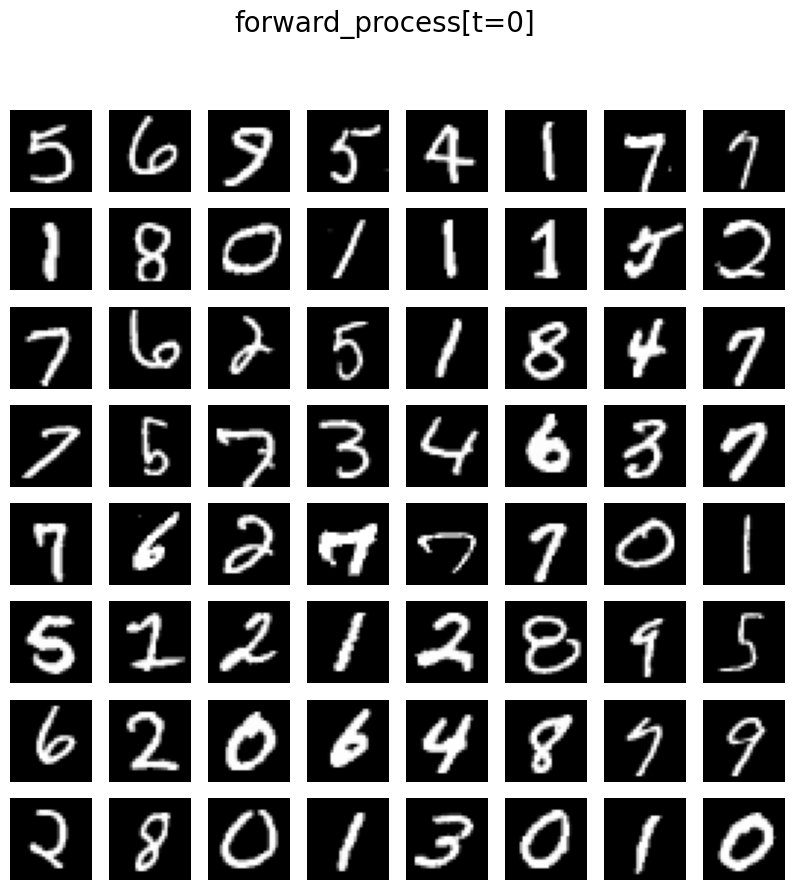

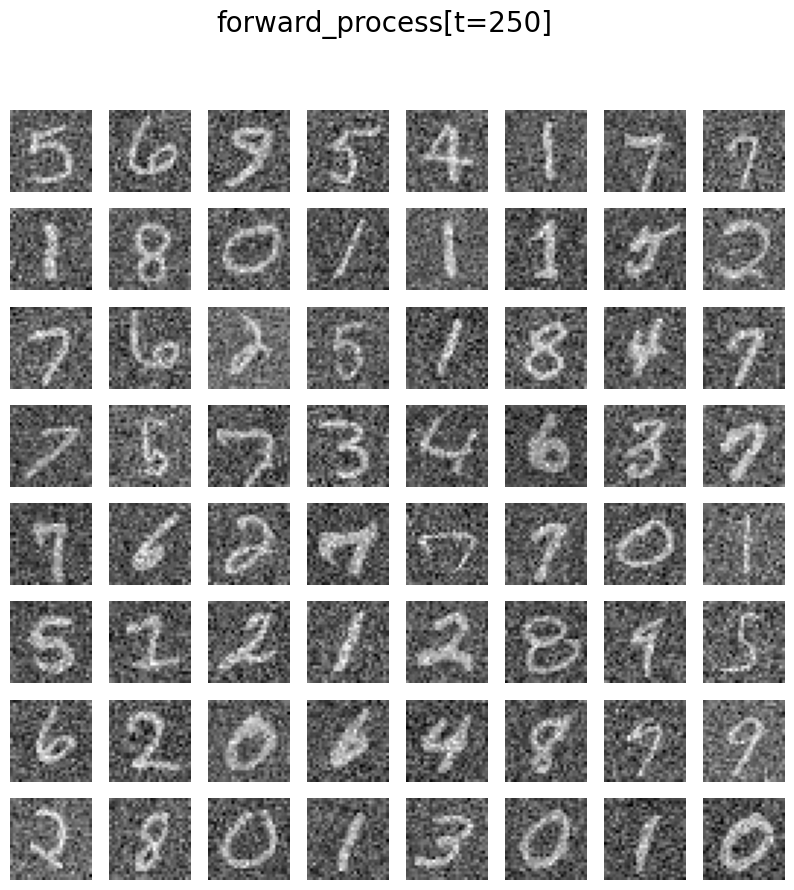

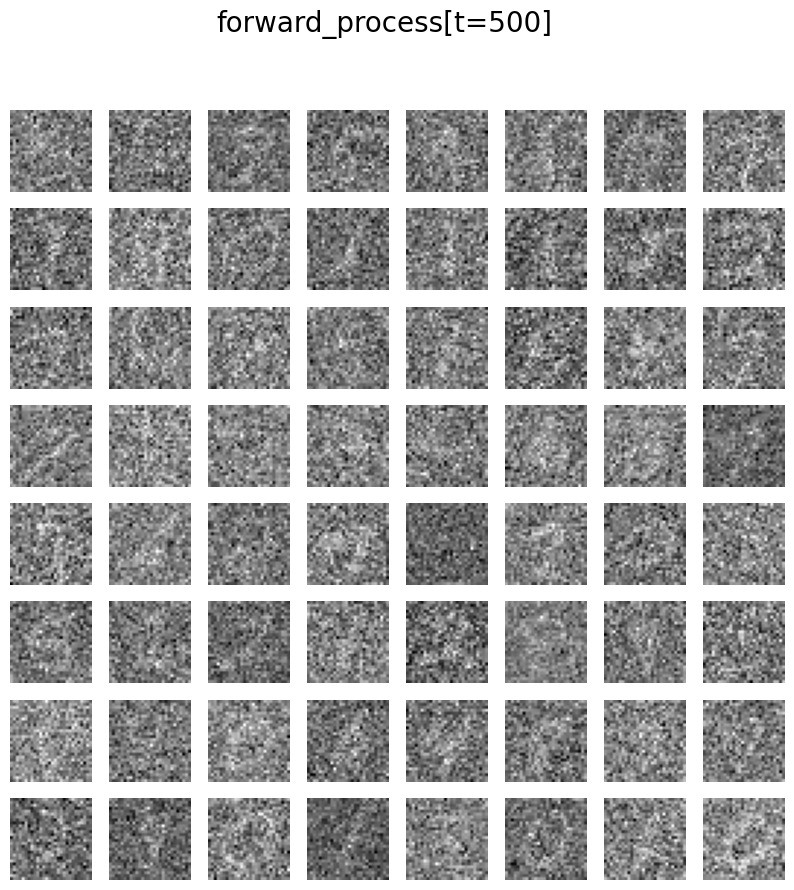

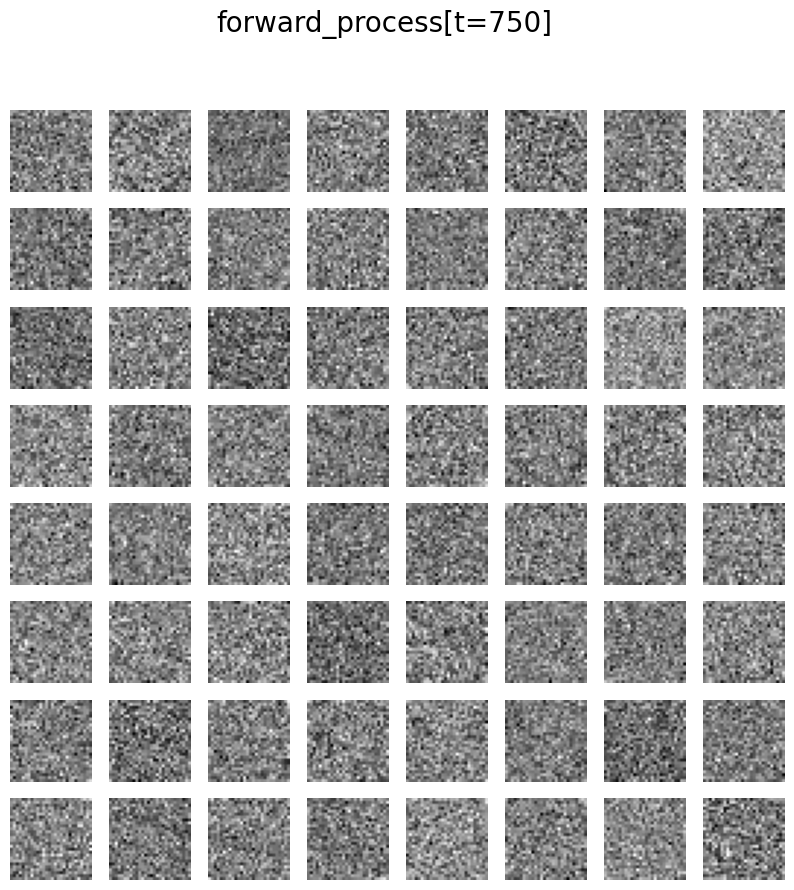

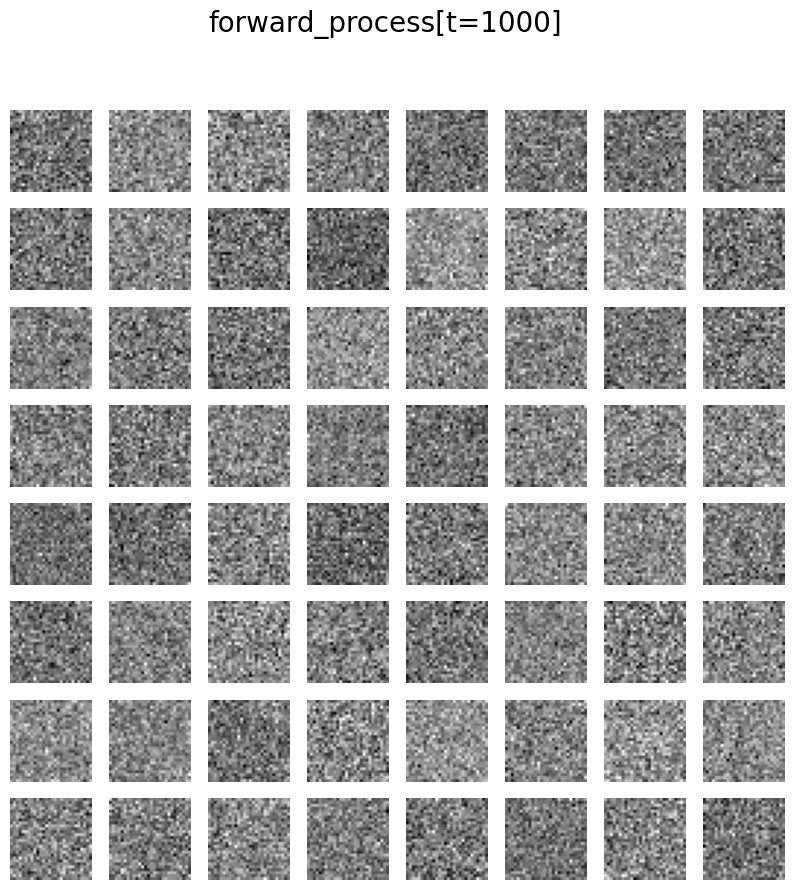

In [193]:
plot_forward(model, dataloader, device)

In [214]:
def sample(model, n_samples, img_shape, device):    
    with torch.no_grad():
        x = torch.randn(n_samples, *img_shape).to(device)
        
        for t in reversed(range(model.T)):
            t_batch = (torch.ones(n_samples, 1) * t).to(device).long()
            eps_batch = model.backward(x, t_batch)
            
            alpha_t = model.alphas[t]
            alpha_prod = model.alpha_prods[t]

            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_prod).sqrt() * eps_batch)
            
            if t > 0:
                noise = torch.randn(n_samples, *img_shape).to(device)
                
                # option 1 from the article for sigma_t
                # both versions from the article give the same result
                sigma_t = model.betas[t].sqrt()
                
                x = x + sigma_t * noise
            
            if t % 100 == 0:
                plot_images(x, f"sampled[t={t}]", saved=True)

In [195]:
def train(model, dataloader, optimizer, criterion, device, n_epochs):
    loss_log = []
    
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0.0
        
        for img, _ in tqdm(dataloader, desc=f'Epoch {epoch+1}/{n_epochs} loss {loss_log[-1] if len(loss_log) > 0 else 0}'):
            img = img.to(device)
            
            optimizer.zero_grad()
            
            eps = torch.randn_like(img).to(device)
            t = torch.randint(model.T, (img.shape[0],)).to(device)
            destroyed_img = model(img, t, eps)
            
            eps_pred = model.backward(destroyed_img, t)
            
            loss = criterion(eps, eps_pred)
            epoch_loss += loss.item() * img.shape[0] / len(dataloader.dataset)
            
            loss.backward()
            optimizer.step()
        
        loss_log.append(epoch_loss)
    
    return loss_log

In [211]:
n_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [212]:
loss_log = train(model, dataloader, optimizer, criterion, device, n_epochs=n_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 loss 0:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/20 loss 0.12748364329735432:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/20 loss 0.05428796778519952:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/20 loss 0.049141076866785684:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/20 loss 0.045430691727002474:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/20 loss 0.04354049740036333:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/20 loss 0.04241228813529019:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/20 loss 0.04044073865612354:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/20 loss 0.040482528877258284:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/20 loss 0.03941932650605834:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11/20 loss 0.03878949009577435:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12/20 loss 0.0383813237528006:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13/20 loss 0.03780069161454834:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14/20 loss 0.03755762613018356:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15/20 loss 0.037402971787254054:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16/20 loss 0.03698354489604632:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17/20 loss 0.03686258626778928:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18/20 loss 0.03653496260643004:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19/20 loss 0.036561879883209886:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20/20 loss 0.03659998943010968:   0%|          | 0/938 [00:00<?, ?it/s]

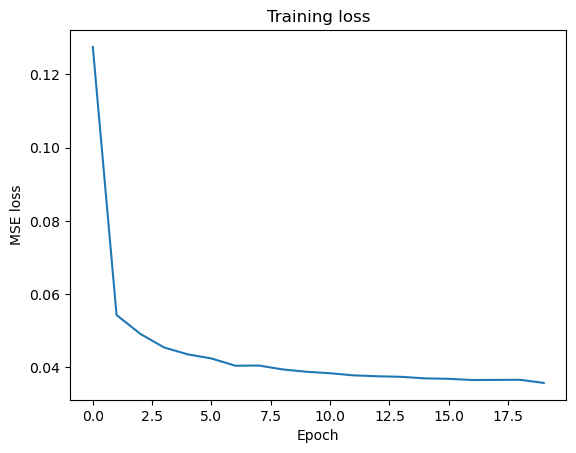

In [213]:
ax = sns.lineplot(loss_log);
ax.set(xlabel='Epoch', ylabel='MSE loss', title='Training loss');

## Сэмплирование

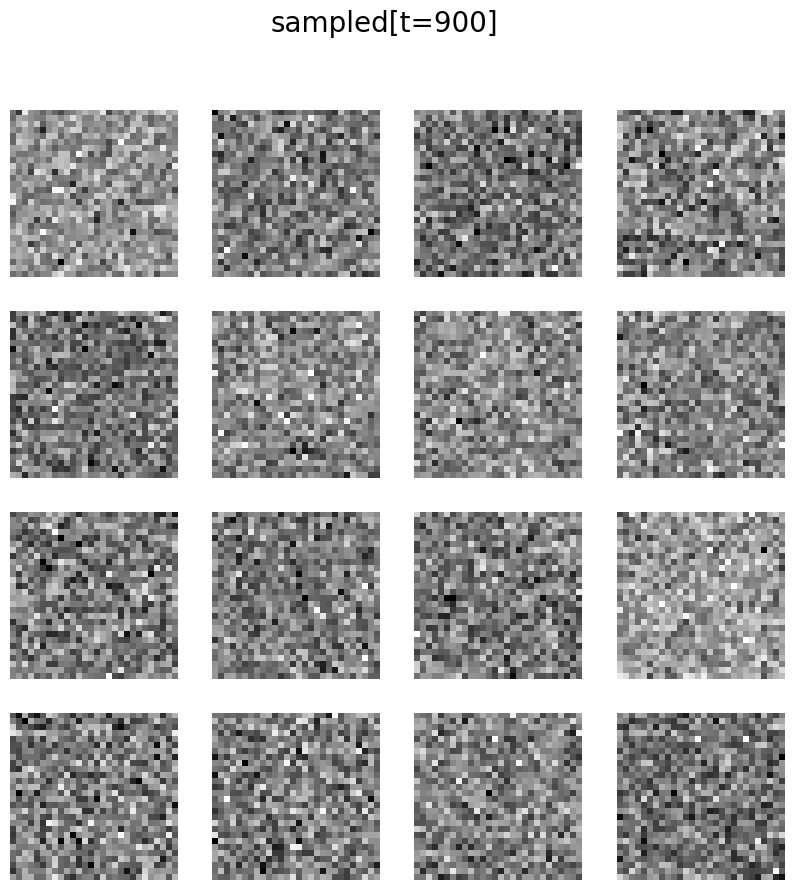

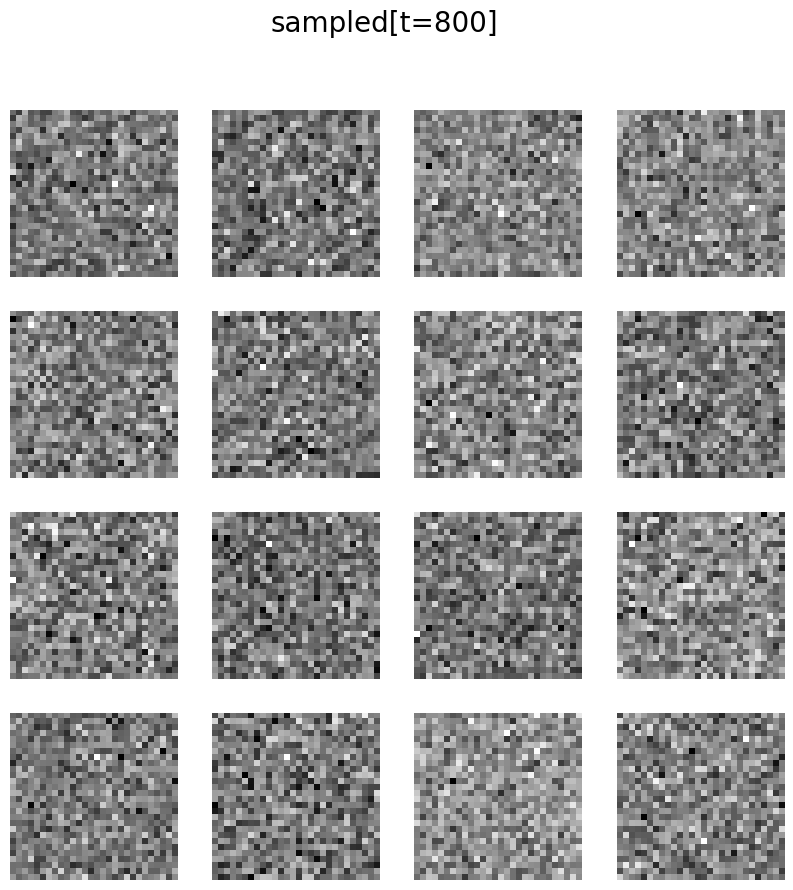

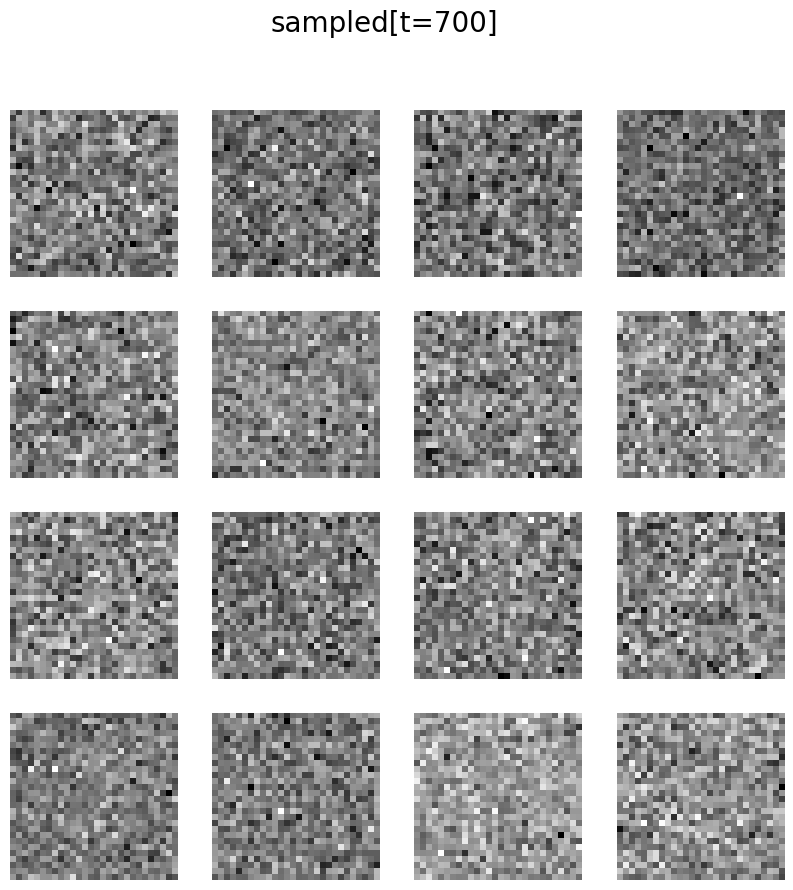

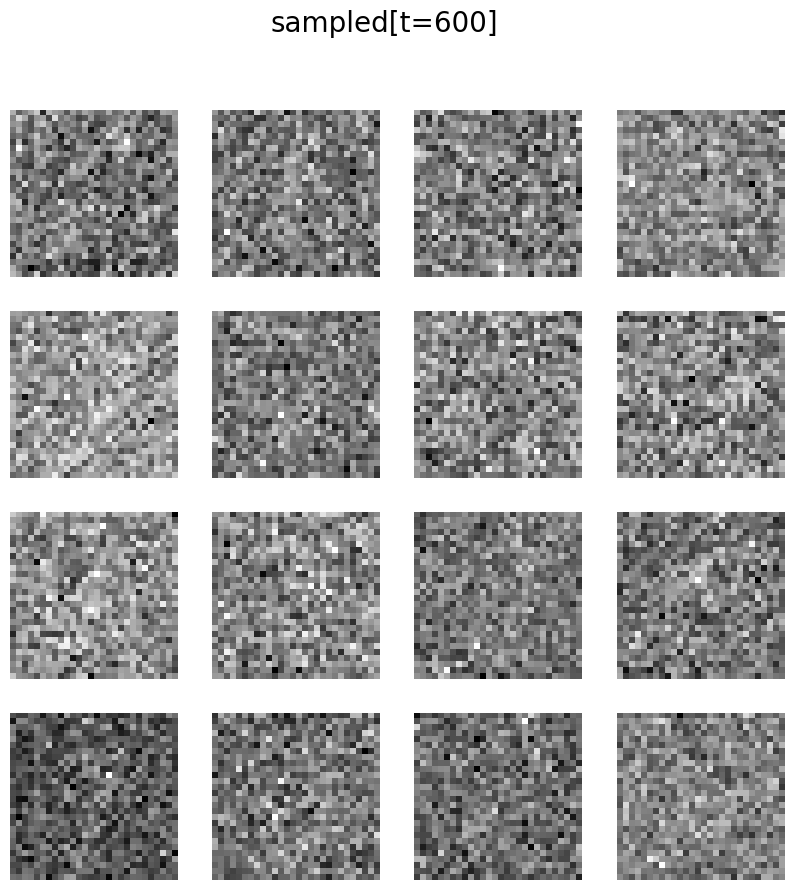

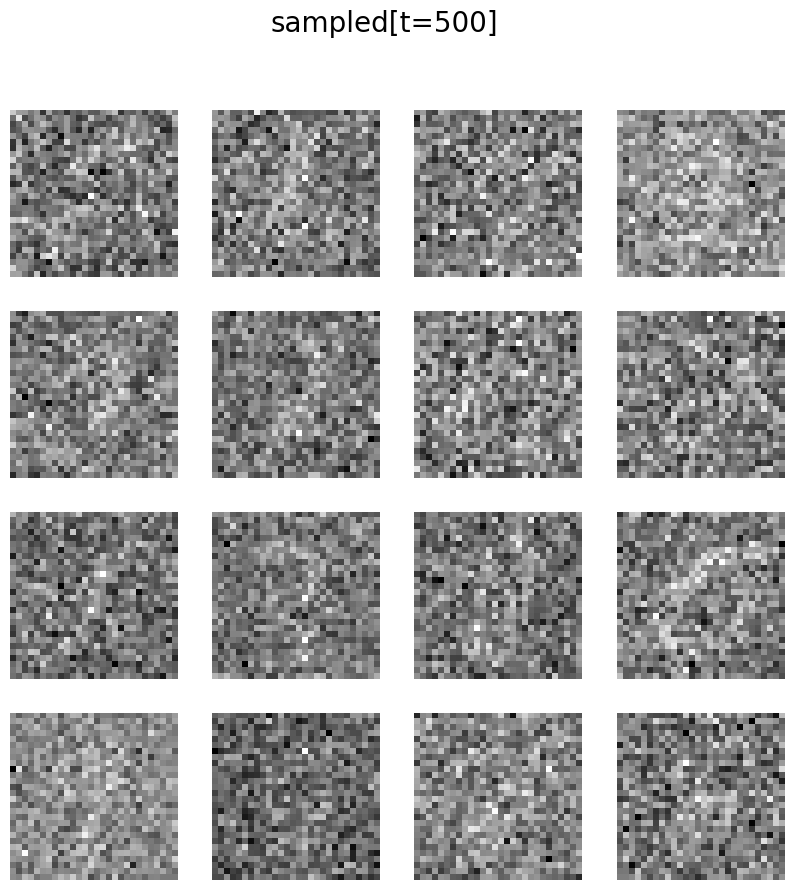

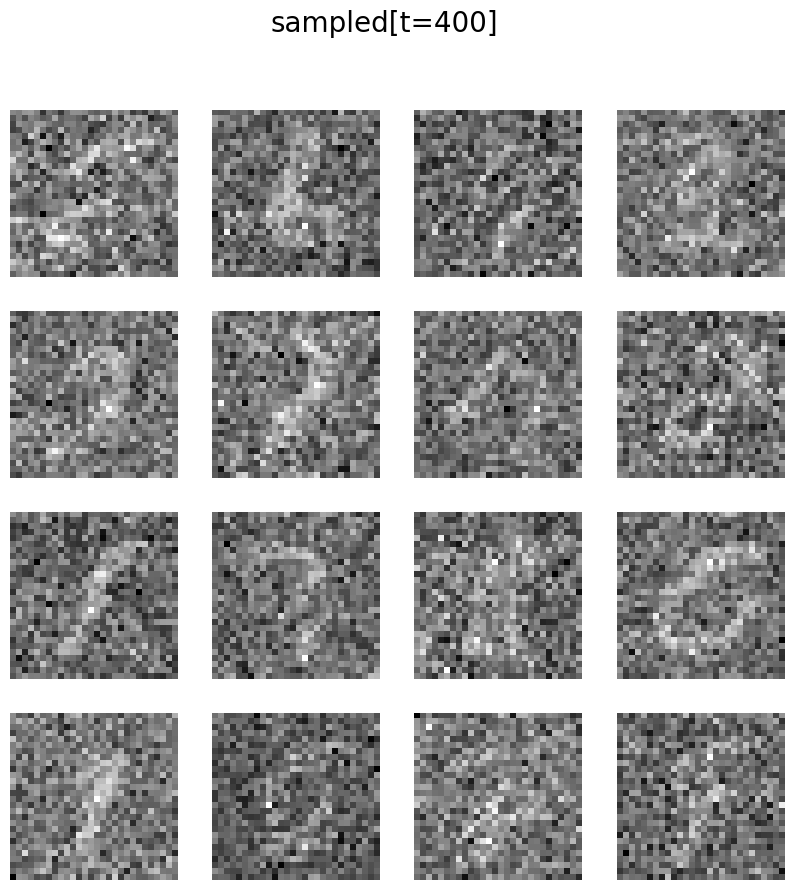

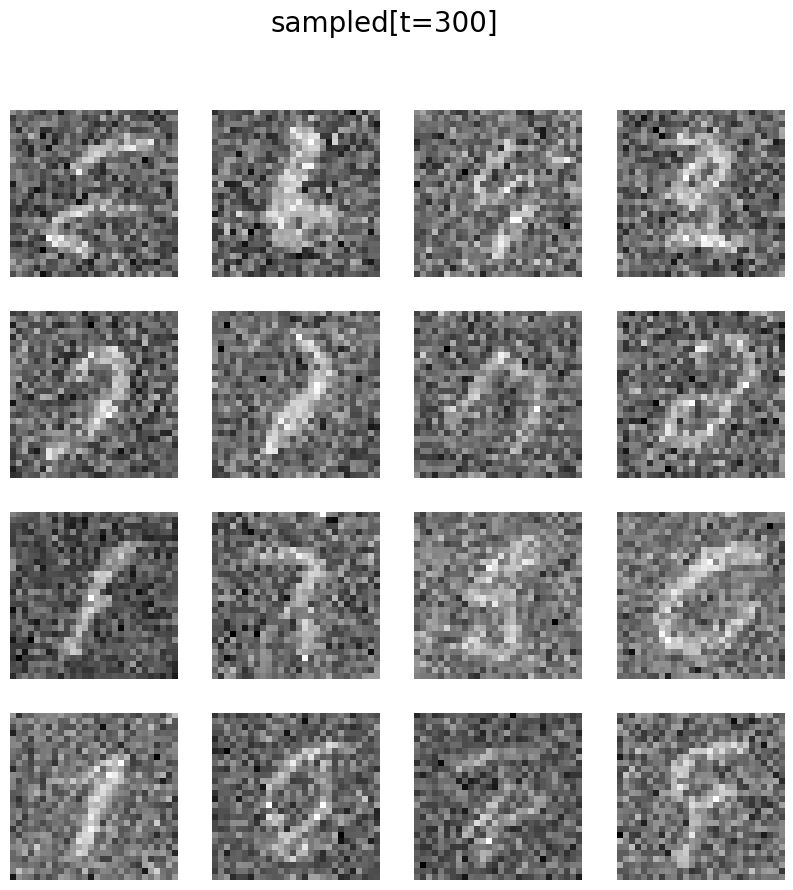

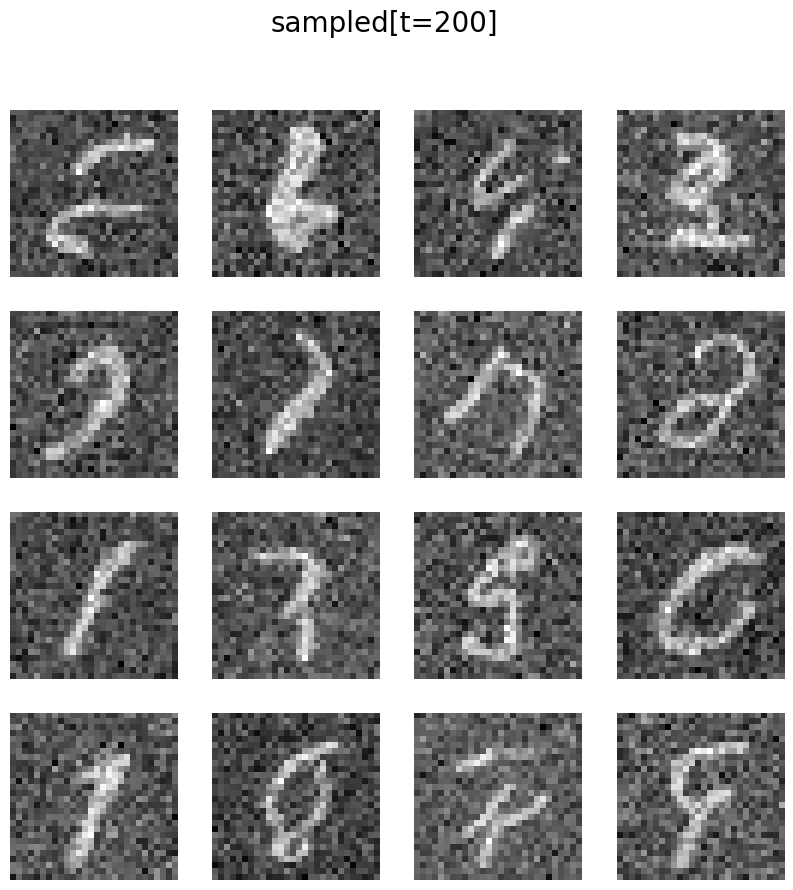

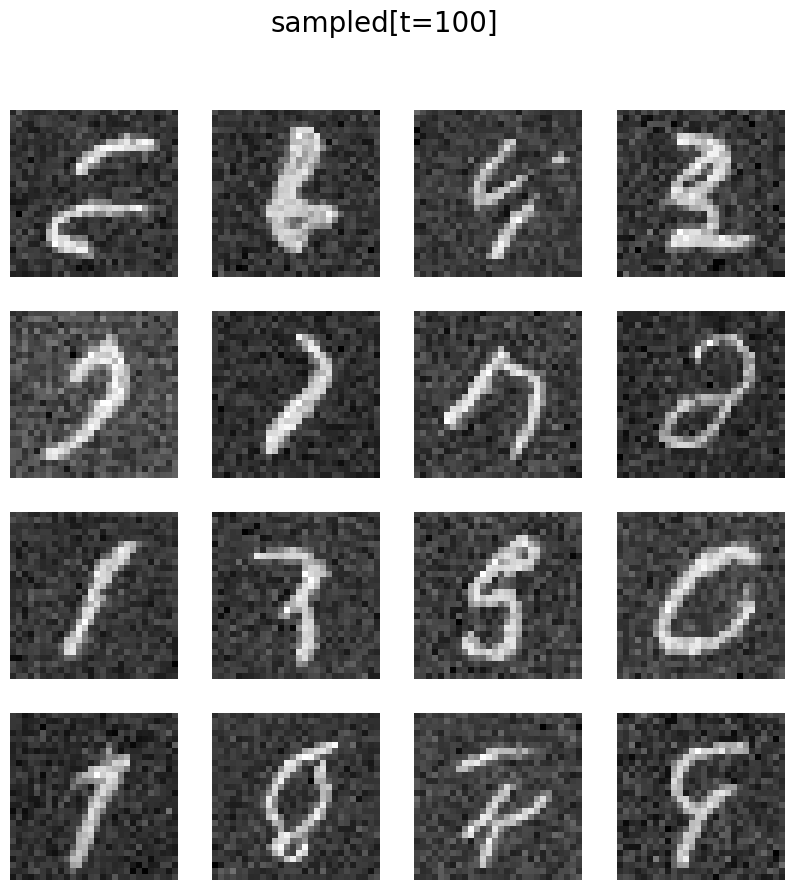

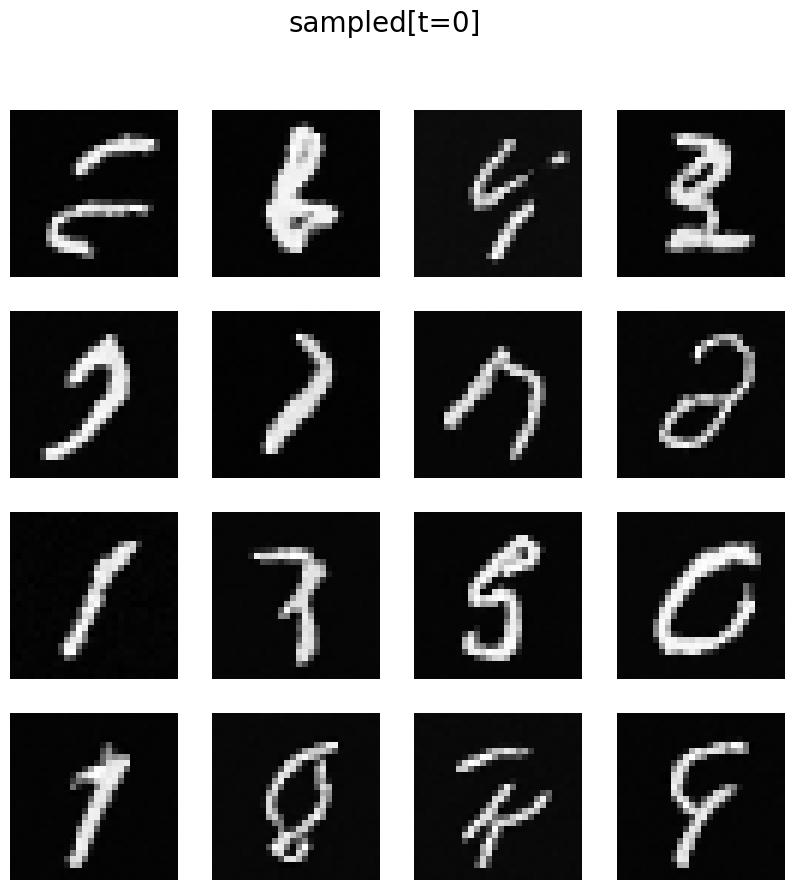

In [215]:
img_shape = tuple(next(iter(dataloader))[0].shape[1:])
sample(model, 16, img_shape, device)